## Data cleaning

In [1]:
import pandas as pd
import numpy as np
#import seaborn as sns
import scipy.io as sio

In [2]:
mat = sio.loadmat("database")

In [3]:
x=mat['Cell1']
for i in range(11):
    print(len(x))
    if i==2:
        x=x[77]# we can move from 0 at 77 to verifie that the number of observation varies
    else: 
        x=x[0]

1
1
78
1
1
4
1
1
4
2580
1


In [4]:
cells = ['Cell1', 'Cell2', 'Cell3', 'Cell4', 'Cell5', 'Cell6', 'Cell7', 'Cell8'] # mat.keys()
cycles = [c for c in str(mat["Cell1"][0][0].dtype).split("'") if "cyc" in c]
types = ['C1ch', 'C1dc', 'OCVch', 'OCVdc'] # mat["Cell1"][0][0][70].dtype
cols = ['t', 'v', 'q', 'T'] 

In [5]:
def is_array(arr):
    try:
        _ = len(arr)
        boul = True
    except:
        boul = False
    return boul 

In [6]:
def inner_nest(arr):
    if is_array(arr):
        while is_array(arr) and len(arr) == 1:
            arr = arr[0]
    return arr 

In [7]:
def nest(arr):
    if not is_array(arr):
        return arr
    elif len(arr) == 1:
        return nest(arr[0]) 
    else:
        ls = [] 
        arr = inner_nest(arr)
        for ar in arr:
            ls.append(nest(ar)) 
        return ls


In [8]:
data = []
for cell in cells:
    data.append(nest(mat[cell])) 

In [9]:
len(data), len(data[0]), len(data[0][0]), len(data[0][0][0]), len(data[0][0][0][0]) 

(8, 78, 4, 4, 3510)

In [10]:
# cells, cycles, types, cols
dfs = []
for cell_id in range(len(cells)):
    for cyc_id in range(len(data[cell_id])):
        for typ_id in range(len(types)):
            #print(cells[cell_id], cycles[cyc_id], types[typ_id])
            arr = np.array(data[cell_id][cyc_id][typ_id]).T   # 4 x 3500 +> 3500 x 4
            df = pd.DataFrame(arr)
            df.columns = cols
            df["type"] = types[typ_id]
            df["cycle"] = cycles[cyc_id]
            df["cell"] = cells[cell_id]
            dfs.append(df)

In [11]:
dff = pd.concat(dfs)

In [12]:
dff.shape

(15264130, 7)

In [13]:
#dff.to_csv("battery.csv")

## Computing SOC

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns

In [15]:
dff = pd.read_csv("battery.csv")

In [16]:
dff["Qplus"] = dff["q"].abs() 

In [17]:
df = dff[dff["cell"] == "Cell1"] 

In [18]:
cyc = df[df["cycle"].isin(["cyc0000"])] 

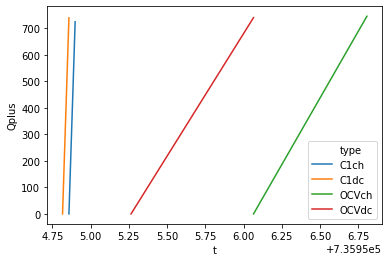

In [19]:
sns.lineplot(data = cyc, x = "t", y = "Qplus", hue = "type") 

In [20]:
maxi = dff.groupby(["cell", "cycle", "type"]).max()
mini = dff.groupby(["cell", "cycle", "type"]).min() 

In [21]:
def scaler(df):
    res= df.apply(lambda r: r["q"] / maxi.loc[r["cell"], r["cycle"], r["type"]]["Qplus"], axis = 1)
    return res


In [22]:
dff["SOC"] = scaler(dff) 

In [23]:
#dff.to_csv("batt_soc.csv") 

In [24]:
dff.head()

,Unnamed: 0,t,v,q,T,type,cycle,cell,Qplus,SOC
0,0,735954.858966,2.719213,-0.000049,41.295536,C1ch,cyc0000,Cell1,0.000049,-6.743288e-08
1,1,735954.858977,2.856135,0.206339,41.000046,C1ch,cyc0000,Cell1,0.206339,2.849508e-04
2,2,735954.858989,2.877108,0.412724,40.962608,C1ch,cyc0000,Cell1,0.412724,5.699658e-04
3,3,735954.859000,2.892908,0.619110,40.987579,C1ch,cyc0000,Cell1,0.619110,8.549822e-04
4,4,735954.859012,2.906382,0.825497,41.049992,C1ch,cyc0000,Cell1,0.825497,1.139999e-03


## Exploration

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
dff = pd.read_csv("/datasets/lit/batt_soc.csv")

FileNotFoundError: [Errno 2] File /datasets/lit/batt_soc.csv does not exist: '/datasets/lit/batt_soc.csv'

In [ ]:
# Considering only battery 
dff = dff[dff["cell"] == "Cell1"].drop(["Unnamed: 0.1", "Unnamed: 0"], axis = 1)

In [ ]:
dff["SOCp"] = dff["SOC"].abs() 

In [ ]:
for cel in cells: 
    for typ in types:
        dff_Cell=dff[dff['cell']==cel]
        dff_Cell=dff_Cell[dff_Cell['type']==typ]
        a=dff_Cell.sample(1000)
        plt.scatter(a['q'],a['v'])
        plt.ylabel('Voltage', fontsize = 15)
        plt.xlabel('Charge', fontsize = 15)
        plt.title('Scarplot of charge and voltage of 100 mesurement randomly selected for '+cel+' and '+typ, fontsize = 15)
        plt.show()

In [ ]:
for cel in cells: 
    for typ in types:
        dff_Cell=dff[dff['cell']==cel]
        dff_Cell=dff_Cell[dff_Cell['type']==typ]
        a=dff_Cell.sample(1000)
        plt.scatter(a['cycle'],a['v'])
        plt.ylabel('Voltage', fontsize = 15)
        plt.xlabel('Cycle', fontsize = 15)
        plt.title('Scarplot of voltage and cycle of 100 mesurement randomly selected for '+cel+' and '+typ, fontsize = 15)
        plt.show()



In [ ]:
dff["cycle"] = dff["cycle"].transform(lambda r: int(r[3:])/100) # cyc3000

In [ ]:
cyc = dff[dff["cycle"] == 50]] 

In [ ]:
# sns.scatterplot(data = dff.sample(5000), x = "v", y = "SOC", hue = "type") 

In [ ]:
_deepnote_run_altair(cyc, """{"data":{"name":"placeholder"},"mark":{"type":"point","tooltip":true},"height":220,"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"encoding":{"x":{"sort":null,"type":"quantitative","field":"v","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"SOCp","scale":{"type":"linear","zero":false}},"color":{"sort":null,"type":"nominal","field":"type","scale":{"type":"linear","zero":false}}}}""")

In [ ]:
_deepnote_run_altair(dff, """{"data":{"name":"placeholder"},"mark":{"type":"point","tooltip":true},"height":220,"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"encoding":{"x":{"sort":null,"type":"quantitative","field":"v","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"SOCp","scale":{"type":"linear","zero":false}},"color":{"sort":null,"type":"nominal","field":"type","scale":{"type":"linear","zero":false}}}}""")

In [ ]:
aggs = dff.groupby(["cell", "cycle", "type"]).max().reset_index() 

In [ ]:
inits = aggs.groupby(["cell", "type"]).max() 

In [ ]:
def scaler(df):
    res= df.apply(lambda r: r["Qplus"] / inits.loc[r["cell"], r["type"]]["Qplus"] , axis = 1)
    return res 


In [ ]:
aggs["SOH"] = scaler(aggs.reset_index()) 

In [ ]:
_deepnote_run_altair(aggs, """{"data":{"name":"placeholder"},"mark":{"type":"line","tooltip":true},"height":220,"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"encoding":{"x":{"sort":null,"type":"quantitative","field":"cycle","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"SOH","scale":{"type":"linear","zero":false}},"color":{"sort":null,"type":"nominal","field":"type","scale":{"type":"linear","zero":false}}}}""")

## Modelling 

In [ ]:
from sklearn import linear_model 
from sklearn.metrics import mean_squared_error

In [ ]:
def transf(x):
    x = 0.999 * (x + 0.001) / 1.001
    return np.log(x/ (1 - x)) 
def inv_transf(x):
    x = np.exp(x)/ (1 + np.exp(x)) 
    return (x * 1.001 / 0.999) - 0.001

In [ ]:
dff["y"] = transf(dff["SOCp"]) 

In [ ]:
dff["y"].min(), dff["y"].max()

In [ ]:
def feats(df):
    df["v2"] = df["v"]**2
    df["v3"] = df["v"]**3
    return df 

In [ ]:
dff = feats(dff) 

In [ ]:
dff["type"].unique()

In [ ]:
def modelize(df, typ, n):
    df_train = dff[(dff["cycle"] < n) & (dff["type"] == typ)] 
    df_test = dff[(dff["cycle"] >= n) & (dff["type"] == typ)] 
    model = linear_model.LinearRegression()  
    X = df_train[["v", "v2", "v3"]].to_numpy()
    y = df_train["y"].to_numpy()
    X_ = df_test[["v", "v2", "v3"]].to_numpy()
    y_ = df_test["y"].to_numpy()
    model.fit(X, y) 
    sc_tr = mean_squared_error(y, model.predict(X)) 
    sc_ts = mean_squared_error(y_, model.predict(X_)) 
    print("Train score: ", sc_tr) 
    print("Test score: ", sc_ts) 
    print("Train R2: ", model.score(X,y)) 
    print("Test R2: ", model.score(X_,y_)) 
    return model 

In [ ]:
models = {}
dff["estSOC"] = 0
for tp in dff["type"].unique():
    print("Type is ", tp)
    model = modelize(dff, tp, 1) 
    models[tp] = model  
    yp = model.predict(dff.loc[dff["type"] == tp, ["v", "v2", "v3"]].to_numpy())
    dff.loc[dff["type"] == tp, "estSOC"] = inv_transf(yp)   

In [ ]:
_deepnote_run_altair(dff, """{"data":{"name":"placeholder"},"mark":{"type":"point","tooltip":true},"height":220,"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"encoding":{"x":{"sort":null,"type":"quantitative","field":"v","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"estSOC","scale":{"type":"linear","zero":false}},"color":{"sort":null,"type":"nominal","field":"type","scale":{"type":"linear","zero":false}}}}""")

In [ ]:
dff["err"] = (dff["estSOC"] - dff["SOCp"])

In [ ]:
#dff["err_origin"] = (dff["estSOC"] - dff["SOCp"]) 

In [ ]:
_deepnote_run_altair(dff, """{"data":{"name":"placeholder"},"mark":{"type":"point","tooltip":true},"height":220,"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"encoding":{"x":{"sort":null,"type":"quantitative","field":"SOCp","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"err","scale":{"type":"linear","zero":false}},"color":{"sort":null,"type":"nominal","field":"type","scale":{"type":"linear","zero":false}}}}""")

In [ ]:
def lic(x):
    return x[0]

In [ ]:
lic = lambda x, y: x + y

In [ ]:
lic(3,4) 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e75d5b8b-47f7-4be6-badd-a468417d5a17' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>